In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization,
    Dense, Dropout, Flatten, LeakyReLU, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
import warnings
import kagglehub
warnings.filterwarnings('ignore')

In [ ]:
!pip freeze > requirements.txt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
DATASET_PATH = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", DATASET_PATH)

DATASET_PATH = os.path.join(DATASET_PATH, 'Dataset')

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 1.68G/1.68G [00:08<00:00, 216MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset


In [4]:
# %%
# Configuration parameters
CONFIG = {
    'INPUT_SHAPE': (160, 160, 3),
    'BATCH_SIZE': 64,
    'LEARNING_RATE': 0.01,
    'EPOCHS': 200,  # You can reduce this for faster training (e.g., 50-100)
    'MODEL_NAME': 'best_deepfake_detector.h5'
}

In [5]:
class DeepfakeDetector:
    def __init__(self, input_shape=(160, 160, 3), learning_rate=0.01):
        """
        Initialize the Deepfake Detector with D-CNN architecture
        """
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.model = None
        self.history = None

    def build_model(self):
        """
        Build the D-CNN model architecture as described in the paper
        """
        print("Building D-CNN architecture...")

        model = Sequential()

        # Block 1: Initial feature extraction
        model.add(Conv2D(8, (3, 3), input_shape=self.input_shape, padding='same', name='conv1'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())

        # Block 2: Two conv layers with 16 filters
        model.add(Conv2D(16, (3, 3), padding='same', name='conv2_1'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(16, (3, 3), padding='same', name='conv2_2'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(AveragePooling2D(pool_size=(2, 2), name='avgpool1'))

        # Block 3: Three conv layers with 32 filters
        model.add(Conv2D(32, (3, 3), padding='same', name='conv3_1'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(32, (3, 3), padding='same', name='conv3_2'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(32, (3, 3), padding='same', name='conv3_3'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(AveragePooling2D(pool_size=(2, 2), name='avgpool2'))

        # Block 4: Four conv layers with 64 filters
        model.add(Conv2D(64, (3, 3), padding='same', name='conv4_1'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(64, (3, 3), padding='same', name='conv4_2'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(64, (3, 3), padding='same', name='conv4_3'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(64, (3, 3), padding='same', name='conv4_4'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(AveragePooling2D(pool_size=(2, 2), name='avgpool3'))

        # Block 5: Conv layer with 128 filters using (5,5) filter
        model.add(Conv2D(128, (5, 5), padding='same', name='conv5'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))

        # Block 6: Conv layer with 256 filters using (5,5) filter
        model.add(Conv2D(256, (5, 5), padding='same', name='conv6'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))

        # Flatten and Dense layers
        model.add(Flatten())
        model.add(Dropout(0.5, name='dropout1'))

        # Fully connected layers
        model.add(Dense(32, name='fc1'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5, name='dropout2'))

        model.add(Dense(16, name='fc2'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5, name='dropout3'))

        model.add(Dense(16, name='fc3'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5, name='dropout4'))

        # Output layer
        model.add(Dense(1, activation='sigmoid', name='output'))

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        print("✓ Model architecture built successfully!")
        return model

In [6]:
# %%
# Initialize the detector
detector = DeepfakeDetector(
    input_shape=CONFIG['INPUT_SHAPE'],
    learning_rate=CONFIG['LEARNING_RATE']
)

In [7]:
# Build and display model
model = detector.build_model()
model.summary()

Building D-CNN architecture...
✓ Model architecture built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 160, 160, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 160, 160, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 160, 160, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 160, 160, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool1 (AveragePooling2D)     │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2 (AveragePooling2D)     │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_3 (Conv2D)                │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,388,177 (5.30 MB)

 Trainable params: 1,387,169 (5.29 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [8]:
def create_data_generators(dataset_path, batch_size=64):
    """
    Create data generators for training, validation, and testing
    """
    print("Creating data generators...")

    # Data augmentation for training (as described in the paper)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=360,  # Random rotation 0-360 degrees
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    # Only rescaling for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'Train'),
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Real', 'Fake'],  # Real=0, Fake=1
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'Validate'),
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Real', 'Fake'],
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'Test'),
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Real', 'Fake'],
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [11]:
def create_data_generators(dataset_path, batch_size=64, max_per_class=4000):
    """
    Create data generators for training, validation, and testing,
    limiting to max_per_class files per class.
    """
    print("Creating data generators...")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    def build_dataframe(subdir):
        data = []
        for class_name in ["Real", "Fake"]:
            class_dir = os.path.join(dataset_path, subdir, class_name)
            files = os.listdir(class_dir)
            files = files[:max_per_class]  # limit number of files
            for f in files:
                data.append({"filename": os.path.join(class_dir, f), "class": class_name})
        return pd.DataFrame(data)

    # Build DataFrames with capped files
    train_df = build_dataframe("Train")
    val_df   = build_dataframe("Validation")
    test_df  = build_dataframe("Test")

    # Create generators from dataframe
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col="filename",
        y_col="class",
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col="filename",
        y_col="class",
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col="filename",
        y_col="class",
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [12]:
try:
    train_gen,val_gen, test_gen = create_data_generators(
        DATASET_PATH,
        batch_size=CONFIG['BATCH_SIZE']
    )

    print(f"✓ Training samples: {train_gen.samples}")
    print(f"✓ Validation samples: {val_gen.samples}")
    print(f"✓ Test samples: {test_gen.samples}")
    print(f"✓ Class indices: {train_gen.class_indices}")

except Exception as e:
    print(f"❌ Error creating data generators: {e}")
    print("Please check your dataset path and folder structure.")
    print("Expected structure:")
    print("Dataset/")
    print("├── Train/")
    print("│   ├── Real/")
    print("│   └── Fake/")
    print("├── Validate/")
    print("│   ├── Real/")
    print("│   └── Fake/")
    print("└── Test/")
    print("    ├── Real/")
    print("    └── Fake/")

Creating data generators...
Found 8000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.
✓ Training samples: 8000
✓ Validation samples: 8000
✓ Test samples: 8000
✓ Class indices: {'Fake': 0, 'Real': 1}


In [13]:
def visualize_sample_images(generator, num_samples=8):
    """
    Visualize sample images from the generator
    """
    # Get a batch of images
    images, labels = next(generator)

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        label = 'Fake' if labels[i] == 1 else 'Real'
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Sample training images:


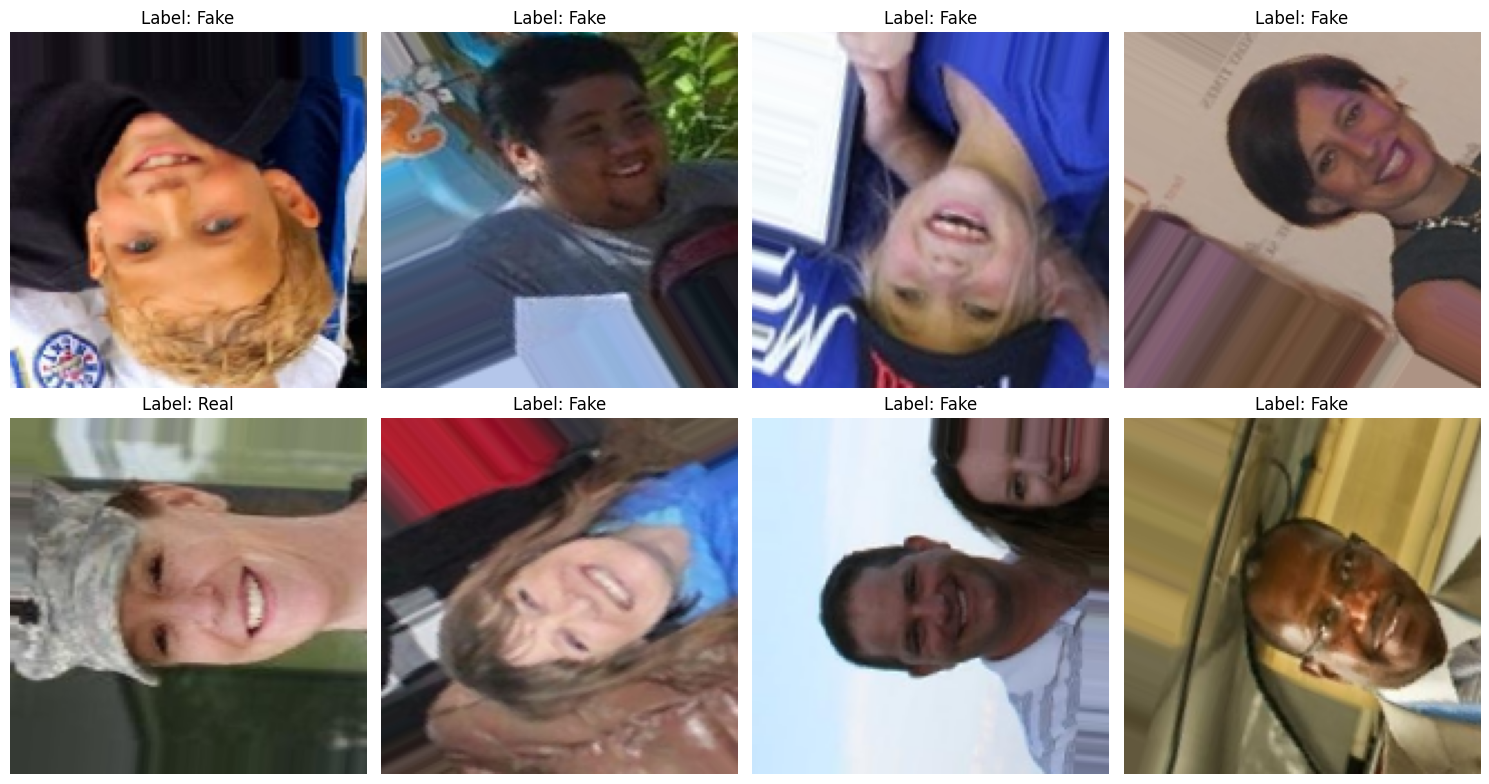

In [14]:
if 'train_gen' in locals():
    print("Sample training images:")
    visualize_sample_images(train_gen)
    # Reset generator
    train_gen.reset()

In [15]:
def setup_callbacks(model_name):
    """
    Setup training callbacks
    """
    callbacks = [
        ModelCheckpoint(
            model_name,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1,
            # save_format='h5'
        ),
        CSVLogger('training_log.csv'),
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=25,
            min_lr=0.0001,
            verbose=1
        )
    ]
    return callbacks

In [16]:
callbacks = setup_callbacks(CONFIG['MODEL_NAME'])
print("Training callbacks configured:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")

Training callbacks configured:
- ModelCheckpoint
- CSVLogger
- EarlyStopping
- ReduceLROnPlateau


In [17]:
if 'train_gen' in locals() and 'val_gen' in locals():
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    print(f"Total epochs: {CONFIG['EPOCHS']}")
    print(f"Estimated training time: ~{(steps_per_epoch * CONFIG['EPOCHS']) // 60} minutes")

Steps per epoch: 125
Validation steps: 125
Total epochs: 200
Estimated training time: ~416 minutes


In [18]:
print("🚀 Starting model training...")
print("This may take a while depending on your hardware and number of epochs.")
print(f"Training for {CONFIG['EPOCHS']} epochs...")

if 'train_gen' in locals() and 'val_gen' in locals() and detector.model is not None:
    try:
        # Start the training process
        history = detector.model.fit(
            train_gen,
            # steps_per_epoch=steps_per_epoch,
            epochs=CONFIG['EPOCHS'],
            validation_data=val_gen,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        # Store history in detector object
        detector.history = history
        print("✅ Training completed successfully!")

        # Display final training metrics
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        print(f"Final Training Accuracy: {final_train_acc:.4f}")
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")

    except Exception as e:
        print(f"❌ Training failed with error: {e}")
        print("Please check your data generators and model setup.")

else:
    print("❌ Cannot start training. Requirements:")
    print(f"  - train_gen exists: {'train_gen' in locals()}")
    print(f"  - val_gen exists: {'val_gen' in locals()}")
    print(f"  - model exists: {detector.model is not None}")
    print("Please ensure data generators are created successfully and model is built.")

🚀 Starting model training...
This may take a while depending on your hardware and number of epochs.
Training for 200 epochs...
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5159 - loss: 1.5693
Epoch 1: val_loss improved from inf to 0.69530, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 510ms/step - accuracy: 0.5157 - loss: 1.5654 - val_accuracy: 0.4895 - val_loss: 0.6953 - learning_rate: 0.0100
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4951 - loss: 0.7032
Epoch 2: val_loss improved from 0.69530 to 0.69258, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 498ms/step - accuracy: 0.4951 - loss: 0.7032 - val_accuracy: 0.5329 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5087 - loss: 0.6957
Epoch 3: val_loss did not improve from 0.69258
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.5087 - loss: 0.6957 - val_accuracy: 0.5020 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5102 - loss: 0.6951
Epoch 4: val_loss did not improve from 0.69258
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 499ms/step - accuracy: 0.5101 - loss: 0.6951 - val_accuracy: 0.5004 - val_loss: 0.6929 - learning_rate: 0.0100
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5122 - loss: 0.6948
Epoch 5: val_loss did not improve from 0.69258
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.5123 - loss: 0.6948 - val_accuracy: 0.5001 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 6/200
125/

125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5773 - val_loss: 0.6918 - learning_rate: 0.0100
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5140 - loss: 0.6930
Epoch 7: val_loss improved from 0.69183 to 0.69181, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 495ms/step - accuracy: 0.5140 - loss: 0.6930 - val_accuracy: 0.5145 - val_loss: 0.6918 - learning_rate: 0.0100
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5308 - loss: 0.6928
Epoch 8: val_loss improved from 0.69181 to 0.69044, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 495ms/step - accuracy: 0.5307 - loss: 0.6928 - val_accuracy: 0.5745 - val_loss: 0.6904 - learning_rate: 0.0100
Epoch 9/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5091 - loss: 0.6937
Epoch 9: val_loss improved from 0.69044 to 0.69018, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 520ms/step - accuracy: 0.5092 - loss: 0.6937 - val_accuracy: 0.5645 - val_loss: 0.6902 - learning_rate: 0.0100
Epoch 10/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5237 - loss: 0.6916
Epoch 10: val_loss did not improve from 0.69018
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 495ms/step - accuracy: 0.5237 - loss: 0.6916 - val_accuracy: 0.5075 - val_loss: 0.6916 - learning_rate: 0.0100
Epoch 11/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5308 - loss: 0.6908
Epoch 11: val_loss did not improve from 0.69018
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.5307 - loss: 0.6908 - val_accuracy: 0.5126 - val_loss: 0.6907 - learning_rate: 0.0100
Epoch 12/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5222 - loss: 0.6918
Epoch 12: val_loss did not improve from 0.69018
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 494ms/step - accuracy: 0.5222 - loss: 0.6918 - val_accuracy: 0.5261 - val_loss: 0.6915 - learning_rate: 0.0100
Epoch 13/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 496ms/step - accuracy: 0.5180 - loss: 0.6948 - val_accuracy: 0.5838 - val_loss: 0.6898 - learning_rate: 0.0100
Epoch 15/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5170 - loss: 0.6926
Epoch 15: val_loss did not improve from 0.68982
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.5171 - loss: 0.6926 - val_accuracy: 0.5010 - val_loss: 0.6910 - learning_rate: 0.0100
Epoch 16/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5244 - loss: 0.6931
Epoch 16: val_loss improved from 0.68982 to 0.68840, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 493ms/step - accuracy: 0.5243 - loss: 0.6931 - val_accuracy: 0.5921 - val_loss: 0.6884 - learning_rate: 0.0100
Epoch 17/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5309 - loss: 0.6883
Epoch 17: val_loss did not improve from 0.68840
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.5309 - loss: 0.6884 - val_accuracy: 0.5001 - val_loss: 0.6950 - learning_rate: 0.0100
Epoch 18/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5385 - loss: 0.6875
Epoch 18: val_loss did not improve from 0.68840
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.5386 - loss: 0.6875 - val_accuracy: 0.4946 - val_loss: 0.6941 - learning_rate: 0.0100
Epoch 19/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5270 - loss: 0.6900
Epoch 19: val_loss did not improve from 0.68840
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.5270 - loss: 0.6900 - val_accuracy: 0.5005 - val_loss: 0.6939 - learning_rate: 0.0100
Epoch 20/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.5451 - loss: 0.6844 - val_accuracy: 0.5586 - val_loss: 0.6853 - learning_rate: 0.0100
Epoch 21/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5640 - loss: 0.6829
Epoch 21: val_loss did not improve from 0.68531
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 493ms/step - accuracy: 0.5639 - loss: 0.6830 - val_accuracy: 0.5230 - val_loss: 0.6921 - learning_rate: 0.0100
Epoch 22/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5655 - loss: 0.6872
Epoch 22: val_loss did not improve from 0.68531
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 496ms/step - accuracy: 0.5654 - loss: 0.6872 - val_accuracy: 0.5019 - val_loss: 0.6931 - learning_rate: 0.0100
Epoch 23/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5638 - loss: 0.6863
Epoch 23: val_loss improved from 0.68531 to 0.67496, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 497ms/step - accuracy: 0.5638 - loss: 0.6863 - val_accuracy: 0.5929 - val_loss: 0.6750 - learning_rate: 0.0100
Epoch 24/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5665 - loss: 0.6842
Epoch 24: val_loss did not improve from 0.67496
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 496ms/step - accuracy: 0.5665 - loss: 0.6842 - val_accuracy: 0.5288 - val_loss: 0.6905 - learning_rate: 0.0100
Epoch 25/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5702 - loss: 0.6805
Epoch 25: val_loss did not improve from 0.67496
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 494ms/step - accuracy: 0.5703 - loss: 0.6805 - val_accuracy: 0.5619 - val_loss: 0.6825 - learning_rate: 0.0100
Epoch 26/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5680 - loss: 0.6827
Epoch 26: val_loss did not improve from 0.67496
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 515ms/step - accuracy: 0.5679 - loss: 0.6827 - val_accuracy: 0.5378 - val_loss: 0.6803 - learning_rate: 0.0100
Epoch 27/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.6031 - loss: 0.6678 - val_accuracy: 0.6016 - val_loss: 0.6649 - learning_rate: 0.0100
Epoch 34/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5834 - loss: 0.6701
Epoch 34: val_loss did not improve from 0.66488
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 497ms/step - accuracy: 0.5833 - loss: 0.6701 - val_accuracy: 0.5263 - val_loss: 0.6915 - learning_rate: 0.0100
Epoch 35/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5738 - loss: 0.6745
Epoch 35: val_loss did not improve from 0.66488
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.5738 - loss: 0.6745 - val_accuracy: 0.5524 - val_loss: 0.6820 - learning_rate: 0.0100
Epoch 36/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5937 - loss: 0.6649
Epoch 36: val_loss did not improve from 0.66488
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.5937 - loss: 0.6649 - val_accuracy: 0.5674 - val_loss: 0.6769 - learning_rate: 0.0100
Epoch 37/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.6536 - loss: 0.6348 - val_accuracy: 0.6540 - val_loss: 0.6253 - learning_rate: 0.0100
Epoch 59/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6506 - loss: 0.6350
Epoch 59: val_loss did not improve from 0.62535
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 515ms/step - accuracy: 0.6505 - loss: 0.6350 - val_accuracy: 0.6091 - val_loss: 0.6556 - learning_rate: 0.0100
Epoch 60/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6496 - loss: 0.6292
Epoch 60: val_loss did not improve from 0.62535
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.6496 - loss: 0.6292 - val_accuracy: 0.5410 - val_loss: 0.6947 - learning_rate: 0.0100
Epoch 61/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6613 - loss: 0.6224
Epoch 61: val_loss did not improve from 0.62535
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.6613 - loss: 0.6224 - val_accuracy: 0.5099 - val_loss: 0.7108 - learning_rate: 0.0100
Epoch 62/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 506ms/step - accuracy: 0.6828 - loss: 0.6003 - val_accuracy: 0.6522 - val_loss: 0.6194 - learning_rate: 0.0100
Epoch 68/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6826 - loss: 0.6082
Epoch 68: val_loss did not improve from 0.61943
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - accuracy: 0.6826 - loss: 0.6081 - val_accuracy: 0.6774 - val_loss: 0.6212 - learning_rate: 0.0100
Epoch 69/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6830 - loss: 0.6021
Epoch 69: val_loss did not improve from 0.61943
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.6830 - loss: 0.6022 - val_accuracy: 0.5535 - val_loss: 0.9045 - learning_rate: 0.0100
Epoch 70/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6773 - loss: 0.6190
Epoch 70: val_loss improved from 0.61943 to 0.61047, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.6773 - loss: 0.6189 - val_accuracy: 0.6755 - val_loss: 0.6105 - learning_rate: 0.0100
Epoch 71/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6664 - loss: 0.6278
Epoch 71: val_loss did not improve from 0.61047
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.6663 - loss: 0.6278 - val_accuracy: 0.5065 - val_loss: 0.7186 - learning_rate: 0.0100
Epoch 72/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6711 - loss: 0.6124
Epoch 72: val_loss did not improve from 0.61047
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - accuracy: 0.6710 - loss: 0.6124 - val_accuracy: 0.5959 - val_loss: 0.7901 - learning_rate: 0.0100
Epoch 73/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6724 - loss: 0.6155
Epoch 73: val_loss did not improve from 0.61047
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.6723 - loss: 0.6155 - val_accuracy: 0.5968 - val_loss: 0.6434 - learning_rate: 0.0100
Epoch 74/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 493ms/step - accuracy: 0.6962 - loss: 0.5936 - val_accuracy: 0.6593 - val_loss: 0.6052 - learning_rate: 0.0100
Epoch 80/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6977 - loss: 0.5900
Epoch 80: val_loss did not improve from 0.60520
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 515ms/step - accuracy: 0.6976 - loss: 0.5900 - val_accuracy: 0.6258 - val_loss: 0.6325 - learning_rate: 0.0100
Epoch 81/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6878 - loss: 0.6014
Epoch 81: val_loss did not improve from 0.60520
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.6877 - loss: 0.6014 - val_accuracy: 0.5638 - val_loss: 0.9815 - learning_rate: 0.0100
Epoch 82/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6897 - loss: 0.6042
Epoch 82: val_loss improved from 0.60520 to 0.56916, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.6897 - loss: 0.6041 - val_accuracy: 0.7178 - val_loss: 0.5692 - learning_rate: 0.0100
Epoch 83/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7039 - loss: 0.5795
Epoch 83: val_loss did not improve from 0.56916
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 486ms/step - accuracy: 0.7038 - loss: 0.5796 - val_accuracy: 0.6381 - val_loss: 0.7376 - learning_rate: 0.0100
Epoch 84/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6993 - loss: 0.5953
Epoch 84: val_loss did not improve from 0.56916
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 495ms/step - accuracy: 0.6992 - loss: 0.5953 - val_accuracy: 0.6591 - val_loss: 0.6759 - learning_rate: 0.0100
Epoch 85/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6921 - loss: 0.6081
Epoch 85: val_loss did not improve from 0.56916
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.6921 - loss: 0.6081 - val_accuracy: 0.7042 - val_loss: 0.5744 - learning_rate: 0.0100
Epoch 86/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - accuracy: 0.7095 - loss: 0.5823 - val_accuracy: 0.6915 - val_loss: 0.5626 - learning_rate: 0.0100
Epoch 95/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7243 - loss: 0.5626
Epoch 95: val_loss did not improve from 0.56257
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.7242 - loss: 0.5628 - val_accuracy: 0.7151 - val_loss: 0.5762 - learning_rate: 0.0100
Epoch 96/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6493 - loss: 0.6702
Epoch 96: val_loss did not improve from 0.56257
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.6492 - loss: 0.6701 - val_accuracy: 0.5645 - val_loss: 0.8349 - learning_rate: 0.0100
Epoch 97/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6899 - loss: 0.6056
Epoch 97: val_loss did not improve from 0.56257
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.6900 - loss: 0.6055 - val_accuracy: 0.6482 - val_loss: 0.6117 - learning_rate: 0.0100
Epoch 98/2

125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 511ms/step - accuracy: 0.7071 - loss: 0.5746 - val_accuracy: 0.7138 - val_loss: 0.5406 - learning_rate: 0.0100
Epoch 106/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7281 - loss: 0.5727
Epoch 106: val_loss did not improve from 0.54065
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.7281 - loss: 0.5726 - val_accuracy: 0.6833 - val_loss: 0.6627 - learning_rate: 0.0100
Epoch 107/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7386 - loss: 0.5483
Epoch 107: val_loss improved from 0.54065 to 0.48423, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 486ms/step - accuracy: 0.7386 - loss: 0.5483 - val_accuracy: 0.7713 - val_loss: 0.4842 - learning_rate: 0.0100
Epoch 108/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7694 - loss: 0.5093
Epoch 108: val_loss did not improve from 0.48423
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.7694 - loss: 0.5093 - val_accuracy: 0.7465 - val_loss: 0.5145 - learning_rate: 0.0100
Epoch 109/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7625 - loss: 0.5164
Epoch 109: val_loss did not improve from 0.48423
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.7625 - loss: 0.5164 - val_accuracy: 0.6718 - val_loss: 0.5735 - learning_rate: 0.0100
Epoch 110/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7712 - loss: 0.5190
Epoch 110: val_loss did not improve from 0.48423
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 493ms/step - accuracy: 0.7712 - loss: 0.5190 - val_accuracy: 0.5907 - val_loss: 0.7382 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.7960 - loss: 0.4703 - val_accuracy: 0.7959 - val_loss: 0.4446 - learning_rate: 0.0100
Epoch 116/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8071 - loss: 0.4591
Epoch 116: val_loss did not improve from 0.44457
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 499ms/step - accuracy: 0.8071 - loss: 0.4591 - val_accuracy: 0.7905 - val_loss: 0.4667 - learning_rate: 0.0100
Epoch 117/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8186 - loss: 0.4424
Epoch 117: val_loss did not improve from 0.44457
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.8186 - loss: 0.4424 - val_accuracy: 0.6819 - val_loss: 0.7115 - learning_rate: 0.0100
Epoch 118/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7952 - loss: 0.4655
Epoch 118: val_loss did not improve from 0.44457
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.7952 - loss: 0.4655 - val_accuracy: 0.7961 - val_loss: 0.4471 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.8098 - loss: 0.4515 - val_accuracy: 0.7969 - val_loss: 0.4338 - learning_rate: 0.0100
Epoch 126/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8158 - loss: 0.4359
Epoch 126: val_loss did not improve from 0.43377
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 508ms/step - accuracy: 0.8157 - loss: 0.4361 - val_accuracy: 0.7091 - val_loss: 0.5805 - learning_rate: 0.0100
Epoch 127/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7904 - loss: 0.4726
Epoch 127: val_loss improved from 0.43377 to 0.42688, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.7904 - loss: 0.4727 - val_accuracy: 0.8030 - val_loss: 0.4269 - learning_rate: 0.0100
Epoch 128/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7851 - loss: 0.4904
Epoch 128: val_loss did not improve from 0.42688
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 493ms/step - accuracy: 0.7851 - loss: 0.4903 - val_accuracy: 0.8044 - val_loss: 0.4317 - learning_rate: 0.0100
Epoch 129/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8087 - loss: 0.4783
Epoch 129: val_loss did not improve from 0.42688
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 496ms/step - accuracy: 0.8087 - loss: 0.4782 - val_accuracy: 0.7701 - val_loss: 0.4772 - learning_rate: 0.0100
Epoch 130/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8422 - loss: 0.3993
Epoch 130: val_loss did not improve from 0.42688
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8421 - loss: 0.3994 - val_accuracy: 0.5142 - val_loss: 1.9819 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.8181 - loss: 0.4238 - val_accuracy: 0.8313 - val_loss: 0.3854 - learning_rate: 0.0100
Epoch 132/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8197 - loss: 0.4274
Epoch 132: val_loss did not improve from 0.38541
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - accuracy: 0.8197 - loss: 0.4273 - val_accuracy: 0.7781 - val_loss: 0.4833 - learning_rate: 0.0100
Epoch 133/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8372 - loss: 0.4015
Epoch 133: val_loss did not improve from 0.38541
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8373 - loss: 0.4014 - val_accuracy: 0.8234 - val_loss: 0.3930 - learning_rate: 0.0100
Epoch 134/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8376 - loss: 0.4019
Epoch 134: val_loss did not improve from 0.38541
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.8376 - loss: 0.4019 - val_accuracy: 0.7224 - val_loss: 0.6566 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.8504 - loss: 0.3678 - val_accuracy: 0.8459 - val_loss: 0.3487 - learning_rate: 0.0100
Epoch 144/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8541 - loss: 0.3815
Epoch 144: val_loss did not improve from 0.34871
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.8541 - loss: 0.3814 - val_accuracy: 0.6934 - val_loss: 0.8607 - learning_rate: 0.0100
Epoch 145/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8526 - loss: 0.3696
Epoch 145: val_loss did not improve from 0.34871
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.8525 - loss: 0.3698 - val_accuracy: 0.4995 - val_loss: 3.1358 - learning_rate: 0.0100
Epoch 146/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8264 - loss: 0.4132
Epoch 146: val_loss did not improve from 0.34871
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.8265 - loss: 0.4130 - val_accuracy: 0.8421 - val_loss: 0.3601 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 514ms/step - accuracy: 0.8319 - loss: 0.4008 - val_accuracy: 0.8540 - val_loss: 0.3358 - learning_rate: 0.0100
Epoch 154/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8644 - loss: 0.3472
Epoch 154: val_loss did not improve from 0.33581
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.8645 - loss: 0.3472 - val_accuracy: 0.7136 - val_loss: 0.8026 - learning_rate: 0.0100
Epoch 155/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8762 - loss: 0.3247
Epoch 155: val_loss did not improve from 0.33581
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8762 - loss: 0.3248 - val_accuracy: 0.7377 - val_loss: 0.6443 - learning_rate: 0.0100
Epoch 156/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8744 - loss: 0.3209
Epoch 156: val_loss did not improve from 0.33581
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.8744 - loss: 0.3210 - val_accuracy: 0.8230 - val_loss: 0.4013 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.8365 - loss: 0.4006 - val_accuracy: 0.8558 - val_loss: 0.3316 - learning_rate: 0.0100
Epoch 165/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8681 - loss: 0.3323
Epoch 165: val_loss did not improve from 0.33164
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.8682 - loss: 0.3322 - val_accuracy: 0.7351 - val_loss: 0.6298 - learning_rate: 0.0100
Epoch 166/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8342 - loss: 0.4399
Epoch 166: val_loss improved from 0.33164 to 0.32323, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step - accuracy: 0.8340 - loss: 0.4404 - val_accuracy: 0.8577 - val_loss: 0.3232 - learning_rate: 0.0100
Epoch 167/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8516 - loss: 0.3593
Epoch 167: val_loss did not improve from 0.32323
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step - accuracy: 0.8516 - loss: 0.3592 - val_accuracy: 0.7031 - val_loss: 0.8709 - learning_rate: 0.0100
Epoch 168/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8483 - loss: 0.3717
Epoch 168: val_loss did not improve from 0.32323
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8484 - loss: 0.3716 - val_accuracy: 0.5247 - val_loss: 1.4388 - learning_rate: 0.0100
Epoch 169/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8548 - loss: 0.3736
Epoch 169: val_loss did not improve from 0.32323
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 485ms/step - accuracy: 0.8549 - loss: 0.3736 - val_accuracy: 0.7734 - val_loss: 0.6201 - learning_rate: 0.0100
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8957 - loss: 0.2974 - val_accuracy: 0.8751 - val_loss: 0.3031 - learning_rate: 0.0050
Epoch 194/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9053 - loss: 0.2552
Epoch 194: val_loss improved from 0.30306 to 0.29612, saving model to best_deepfake_detector.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.9052 - loss: 0.2553 - val_accuracy: 0.8734 - val_loss: 0.2961 - learning_rate: 0.0050
Epoch 195/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8987 - loss: 0.2621
Epoch 195: val_loss did not improve from 0.29612
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.8987 - loss: 0.2620 - val_accuracy: 0.8171 - val_loss: 0.4632 - learning_rate: 0.0050
Epoch 196/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8990 - loss: 0.2723
Epoch 196: val_loss did not improve from 0.29612
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.8990 - loss: 0.2722 - val_accuracy: 0.7995 - val_loss: 0.4938 - learning_rate: 0.0050
Epoch 197/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8947 - loss: 0.2632
Epoch 197: val_loss did not improve from 0.29612
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.8947 - loss: 0.2632 - val_accuracy: 0.8456 - val_loss: 0.3668 - learning_rate: 0.0050
Epoc

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.9046 - loss: 0.2668 - val_accuracy: 0.8885 - val_loss: 0.2705 - learning_rate: 0.0050
Epoch 199/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9095 - loss: 0.2436
Epoch 199: val_loss did not improve from 0.27055
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 494ms/step - accuracy: 0.9095 - loss: 0.2436 - val_accuracy: 0.7050 - val_loss: 0.8784 - learning_rate: 0.0050
Epoch 200/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8932 - loss: 0.2882
Epoch 200: val_loss did not improve from 0.27055
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.8932 - loss: 0.2884 - val_accuracy: 0.8445 - val_loss: 0.3459 - learning_rate: 0.0050
Restoring model weights from the end of the best epoch: 198.
✅ Training completed successfully!
Final Training Accuracy: 0.8856
Final Validation Accuracy: 0.8445


In [19]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print("\n" + "="*50)
    print("FINAL TRAINING METRICS")
    print("="*50)
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print("="*50)

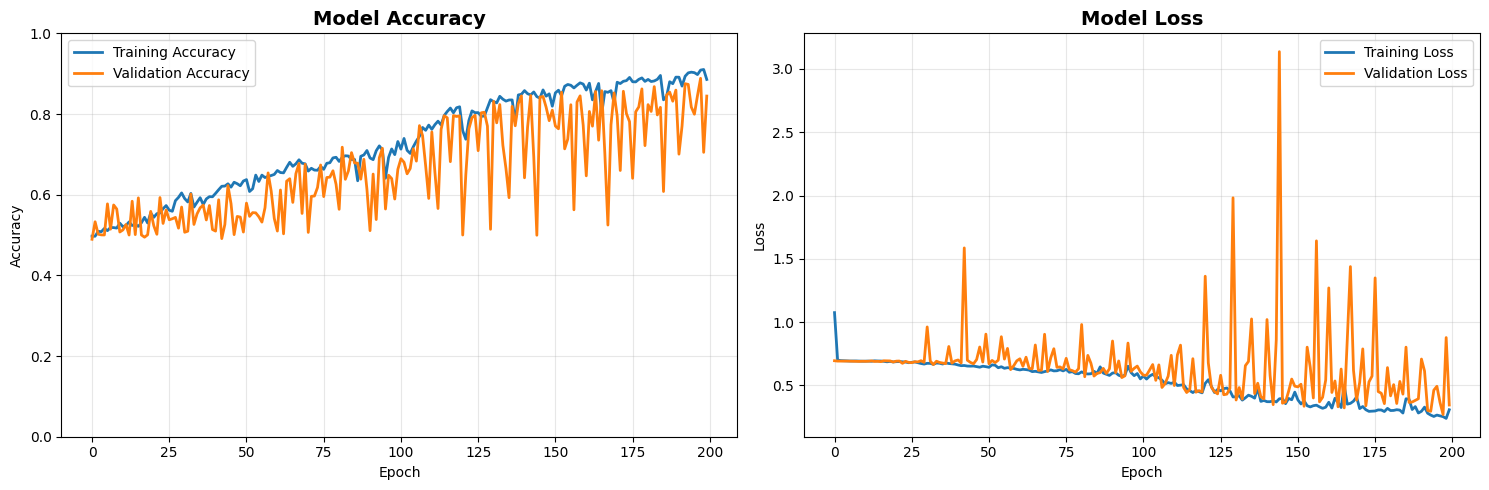


FINAL TRAINING METRICS
Training Accuracy: 0.8856
Validation Accuracy: 0.8445
Training Loss: 0.3084
Validation Loss: 0.3459


In [20]:
if hasattr(detector, 'history') and detector.history is not None:
    plot_training_history(detector.history)

In [21]:
def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data
    """
    print("🔍 Evaluating model on test data...")

    # Predict on test data
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get true labels
    true_labels = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_classes)

    # Classification report
    report = classification_report(
        true_labels,
        predicted_classes,
        target_names=['Real', 'Fake'],
        output_dict=True
    )

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)

    results = {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'predictions': predictions.flatten(),
        'predicted_classes': predicted_classes,
        'true_labels': true_labels
    }

    return results

In [22]:
if 'test_gen' in locals() and detector.model is not None:
    results = evaluate_model(detector.model, test_gen)

    print(f"\n🎯 TEST ACCURACY: {results['accuracy']:.4f}")

    # Print classification report
    print("\n📊 CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(
        results['true_labels'],
        results['predicted_classes'],
        target_names=['Real', 'Fake']
    ))

🔍 Evaluating model on test data...
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step

🎯 TEST ACCURACY: 0.7890

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Real       0.74      0.89      0.81      4000
        Fake       0.86      0.69      0.77      4000

    accuracy                           0.79      8000
   macro avg       0.80      0.79      0.79      8000
weighted avg       0.80      0.79      0.79      8000



In [23]:
def plot_confusion_matrix(cm, class_names=['Real', 'Fake']):
    """
    Plot confusion matrix with enhanced styling
    """
    plt.figure(figsize=(10, 8))

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.title('Confusion Matrix\n(Count and Percentage)', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Calculate and display additional metrics
    tn, fp, fn, tp = cm.ravel()

    precision_real = tn / (tn + fn) if (tn + fn) > 0 else 0
    precision_fake = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_real = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall_fake = tp / (tp + fn) if (tp + fn) > 0 else 0

    print("\n📈 DETAILED METRICS:")
    print("="*40)
    print(f"True Negatives (Real→Real): {tn}")
    print(f"False Positives (Real→Fake): {fp}")
    print(f"False Negatives (Fake→Real): {fn}")
    print(f"True Positives (Fake→Fake): {tp}")
    print("="*40)
    print(f"Precision (Real): {precision_real:.4f}")
    print(f"Precision (Fake): {precision_fake:.4f}")
    print(f"Recall (Real): {recall_real:.4f}")
    print(f"Recall (Fake): {recall_fake:.4f}")

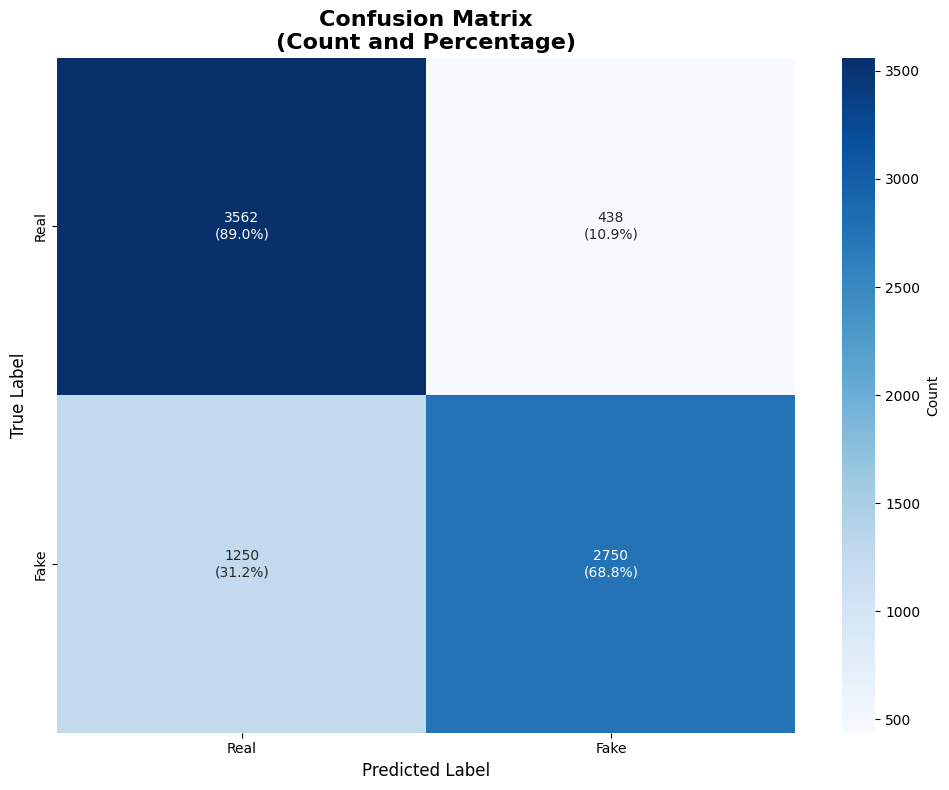


📈 DETAILED METRICS:
True Negatives (Real→Real): 3562
False Positives (Real→Fake): 438
False Negatives (Fake→Real): 1250
True Positives (Fake→Fake): 2750
Precision (Real): 0.7402
Precision (Fake): 0.8626
Recall (Real): 0.8905
Recall (Fake): 0.6875


In [24]:
if 'results' in locals():
    plot_confusion_matrix(results['confusion_matrix'])


In [25]:
def predict_single_image(model, image_path):
    """
    Predict on a single image
    """
    from tensorflow.keras.preprocessing import image

    try:
        # Load and preprocess image
        img = image.load_img(image_path, target_size=(160, 160))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predict
        prediction = model.predict(img_array)[0][0]
        predicted_class = 'Fake' if prediction > 0.5 else 'Real'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.4f}\nScore: {prediction:.4f}',
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()

        return {
            'prediction_score': prediction,
            'predicted_class': predicted_class,
            'confidence': confidence
        }

    except Exception as e:
        print(f"Error predicting image: {e}")
        return None

In [26]:
def save_model(model, filepath):
    """
    Save the trained model
    """
    try:
        model.save(filepath)
        print(f"✓ Model saved successfully to {filepath}")
    except Exception as e:
        print(f"❌ Error saving model: {e}")

def load_saved_model(filepath):
    """
    Load a saved model
    """
    try:
        model = tf.keras.models.load_model(filepath)
        print(f"✓ Model loaded successfully from {filepath}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# %%
# Save the current model
if detector.model is not None:
    save_model(detector.model, f"final_{CONFIG['MODEL_NAME']}")

✓ Model saved successfully to final_best_deepfake_detector.h5


In [27]:
def print_performance_summary():
    """
    Print a comprehensive performance summary
    """
    print("\n" + "="*60)
    print("🎯 DEEPFAKE DETECTION MODEL - PERFORMANCE SUMMARY")
    print("="*60)

    if 'results' in locals():
        print(f"📈 Test Accuracy: {results['accuracy']:.4f}")

        # Get metrics for each class
        report = results['classification_report']
        print(f"\n🔍 REAL IMAGES:")
        print(f"   Precision: {report['Real']['precision']:.4f}")
        print(f"   Recall: {report['Real']['recall']:.4f}")
        print(f"   F1-Score: {report['Real']['f1-score']:.4f}")

        print(f"\n🎭 FAKE IMAGES:")
        print(f"   Precision: {report['Fake']['precision']:.4f}")
        print(f"   Recall: {report['Fake']['recall']:.4f}")
        print(f"   F1-Score: {report['Fake']['f1-score']:.4f}")

        print(f"\n⚖️ OVERALL:")
        print(f"   Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
        print(f"   Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")

    if hasattr(detector, 'history') and detector.history is not None:
        final_val_acc = detector.history.history['val_accuracy'][-1]
        print(f"📊 Final Validation Accuracy: {final_val_acc:.4f}")

    print("\n🏆 MODEL ARCHITECTURE:")
    print(f"   Total Parameters: {detector.model.count_params():,}")
    print(f"   Input Shape: {CONFIG['INPUT_SHAPE']}")
    print(f"   Batch Size: {CONFIG['BATCH_SIZE']}")
    print(f"   Learning Rate: {CONFIG['LEARNING_RATE']}")

    print("="*60)

# %%
# Print final performance summary
print_performance_summary()


🎯 DEEPFAKE DETECTION MODEL - PERFORMANCE SUMMARY
📊 Final Validation Accuracy: 0.8445

🏆 MODEL ARCHITECTURE:
   Total Parameters: 1,388,177
   Input Shape: (160, 160, 3)
   Batch Size: 64
   Learning Rate: 0.01
